In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with h5py.File('furnace_data_1kmu_1e4.hdf5', "r") as infile:
    preds = Tensor(infile['preds'][()])
    targs = Tensor(infile['targs'][()])

In [4]:
def get_volume(size: float = 0.1, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, lwh[2].item() - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - 0.2, 0.2, -size), decimals=2):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, 0.2 - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [5]:
volume = get_volume()

In [6]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4000]), and xy span tensor([4., 4.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3500]), and xy span tensor([4., 4.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3000]), and xy span tensor([4., 4.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.2500]), and xy span tensor([4., 4.])
      )
    )
    (1): PassiveLayer located at z=tensor([1.2000])
    (2): PassiveLayer located at z=tensor([1.1000])
    (3): PassiveLayer located at z=tensor([1.])
    (4): PassiveLayer located at z=tensor([0.9000])
    (5): PassiveLayer located at z=tensor([0.8000])
    (6): PassiveLayer located at z=tensor([0.7000])
    (

# Vars

In [7]:
df = pd.DataFrame(targs.numpy(), columns=['gen_target'])

In [8]:
from tomopt.plotting.appearance import *

def plot_pred(pred, targ):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        print("Zero-ordered target layer ID (including ladel bottom layer):", np.floor((targ-volume.get_passive_z_range()[0]-volume.passive_size)/volume.passive_size))
        plt.show()

In [9]:
ladel_removed = preds[:,1:,1:-1,1:-1]

In [10]:
def get_3d_avg(data):
    return F.avg_pool3d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [11]:
def get_3d_gauss(data):
    gauss = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data =Tensor([[[[[1,2,1],[2,4,2],[1,2,1]],[[2,4,2],[4,8,4],[2,4,2]], [[1,2,1],[2,4,2],[1,2,1]]]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/gauss.weight.sum()

In [12]:
def get_layer_avgs(data):
    return data.mean((-1,-2))

In [13]:
def get_max_sub_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes-mins

In [14]:
def get_max_div_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes/mins

In [15]:
def get_edge_det(data, kernel):
    edge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    edge.weight.data = Tensor([[kernel]])
    edge.requires_grad_(False)
    return edge(data[:,None]).squeeze()

In [16]:
def get_1d_gauss(data):
    gauss = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data = Tensor([[[2,4,2]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/8

In [17]:
def get_1d_avg(data):
    return F.avg_pool1d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [18]:
def get_probs(data):
    return F.softmax(data, dim=-1)

In [19]:
def get_fill_pred(probs, offset=1):
    return ((probs.argmax(-1)+offset)*volume.passive_size)+volume.get_passive_z_range()[0]

In [20]:
def get_mse(fill_pred, targs):
    return ((fill_pred-targs)**2).mean()

In [21]:
def score_data(data, targs, offset=1):
    probs = get_probs(data)
    pred = get_fill_pred(data, offset)
    print(get_mse(pred, targs))

# Tests

In [22]:
# mean
get_mse(targs.mean(), targs)

tensor(0.0680)

In [23]:
# median layer index
d = get_layer_avgs(ladel_removed)
p = ((d.median(1).indices+2)*volume.passive_size)+volume.get_passive_z_range()[0]
get_mse(p, targs)

tensor(0.0951)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


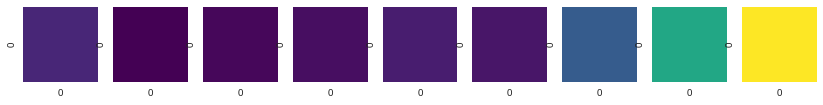

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


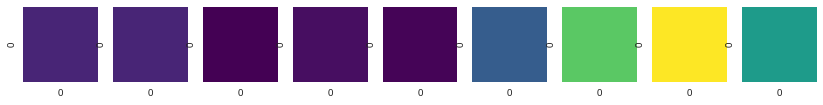

tensor(0.0919)


In [195]:
# max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


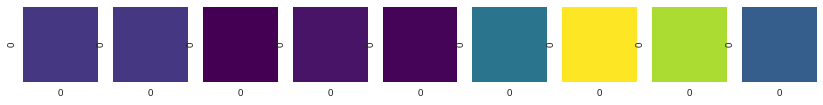

tensor(0.0973)


In [25]:
# max/min
x = get_layer_avgs(ladel_removed)
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


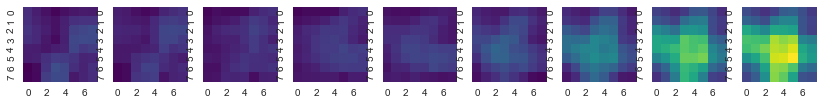

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


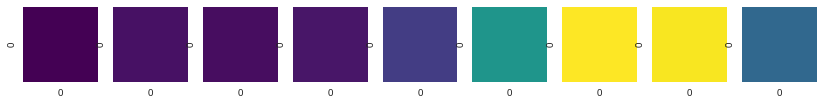

tensor(0.0890)


In [26]:
# pre-avg 3d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


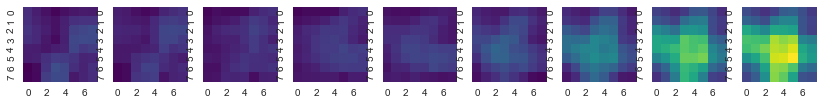

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


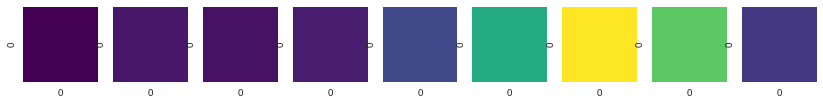

tensor(0.0890)


In [27]:
# pre-avg 3d max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


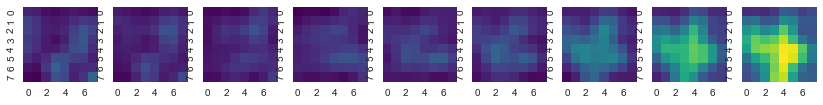

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


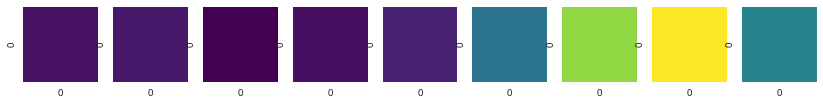

tensor(0.0923)


In [28]:
# pre-gaiss 3d max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


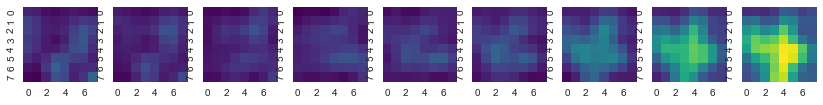

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


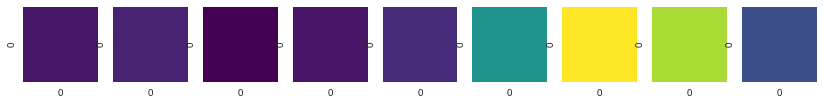

tensor(0.0934)


In [29]:
# pre-gauss 3d max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


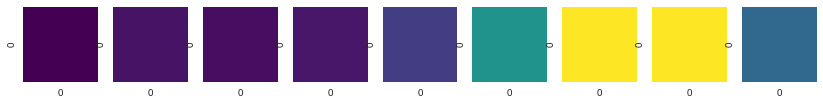

tensor(0.0890)


In [31]:
# avg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


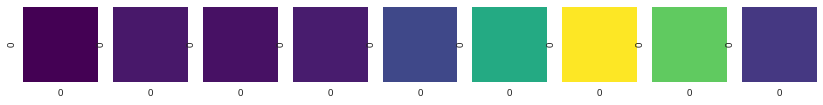

tensor(0.0893)


In [32]:
# avg 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


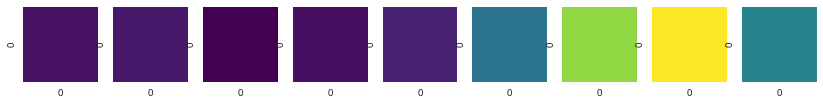

tensor(0.0923)


In [34]:
# gaussg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


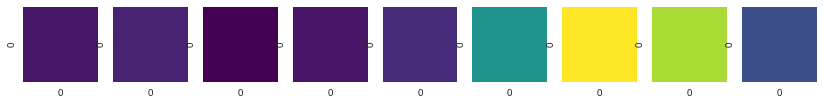

tensor(0.0934)


In [35]:
# gauss 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


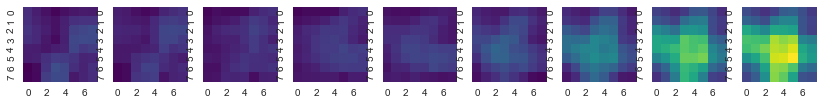

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


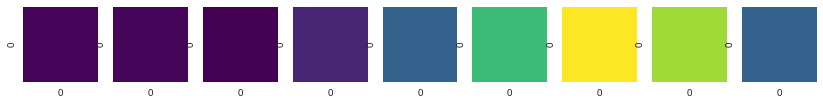

tensor(0.0870)


In [37]:
# pre-avg 3d avg 1d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


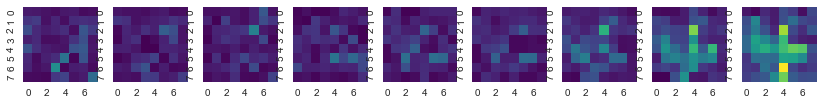

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


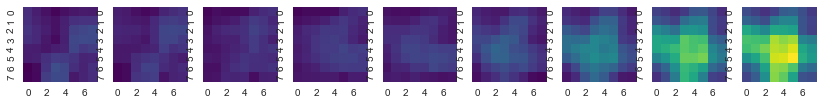

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


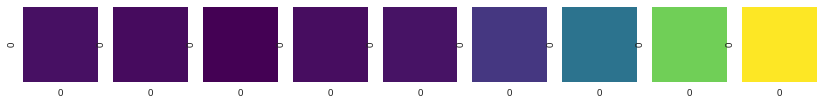

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


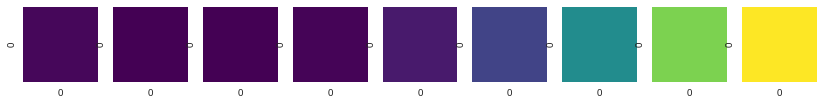

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


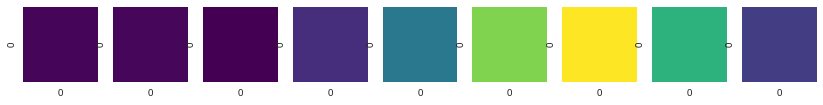

tensor(0.0863)


In [194]:
# pre-avg 3d avg 1d max/min
plot_pred(ladel_removed[0], targs[0])
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

## Ridge -1,x,-1

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


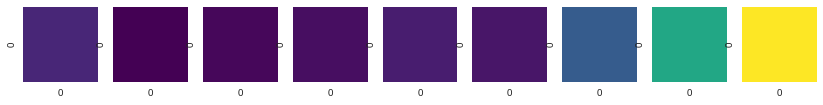

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


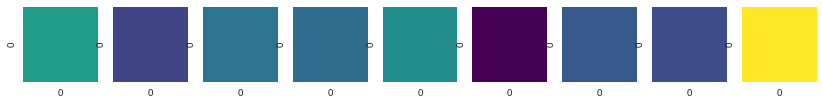

tensor(0.1083)


In [45]:
# Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=-1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


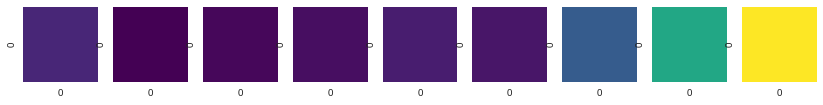

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


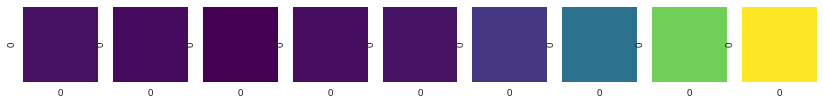

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


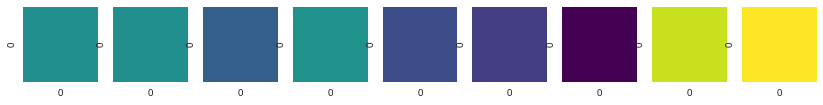

tensor(0.0885)


In [49]:
# 1d avg Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=-1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


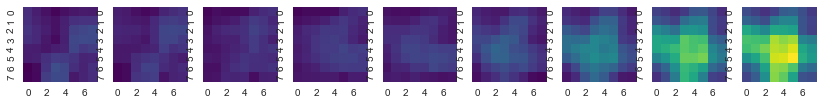

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


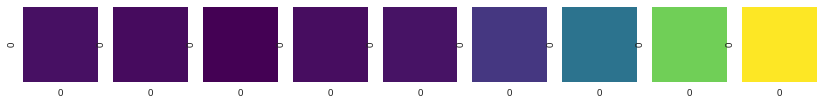

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


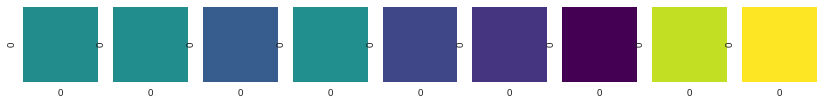

tensor(0.0898)


In [52]:
# 3d avg Ridge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=-1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


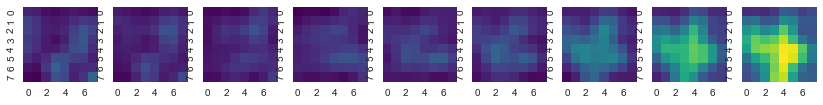

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


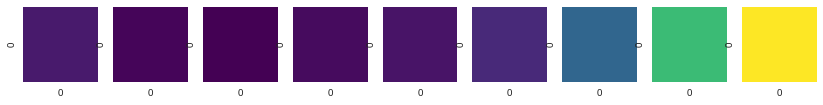

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


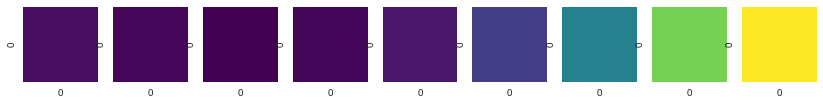

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


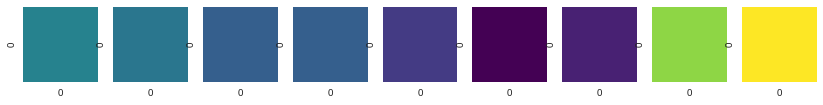

tensor(0.0878)


In [55]:
# 3d avg 1d avg Ridge
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=-1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


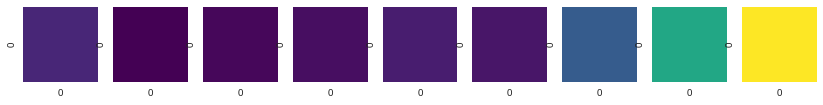

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


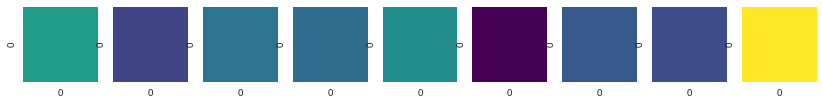

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


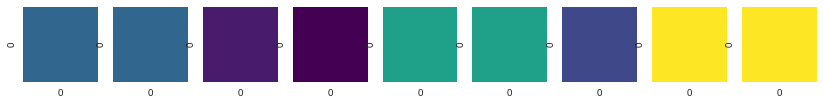

tensor(0.1101)


In [57]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


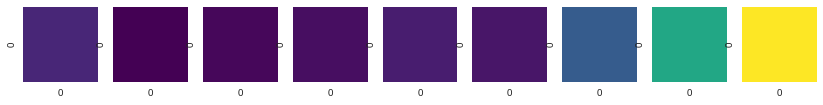

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


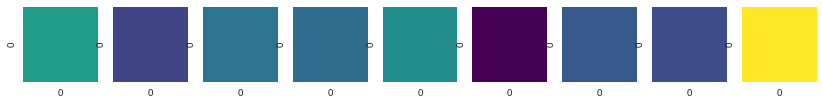

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


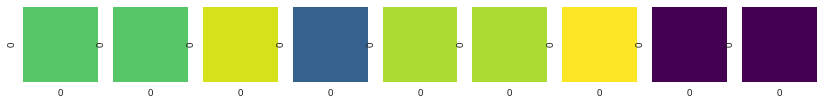

tensor(0.1562)


In [59]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


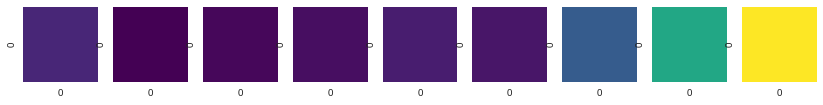

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


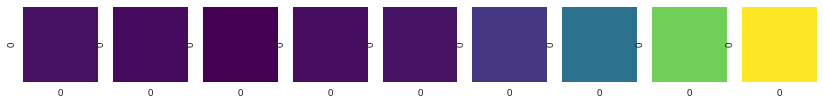

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


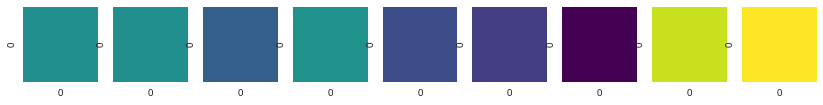

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


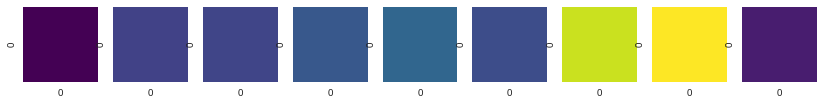

tensor(0.1035)


In [63]:
# 1d avg Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


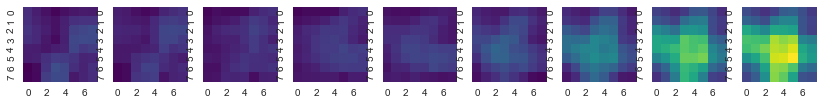

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


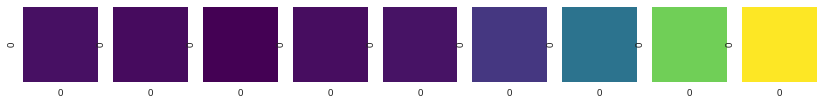

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


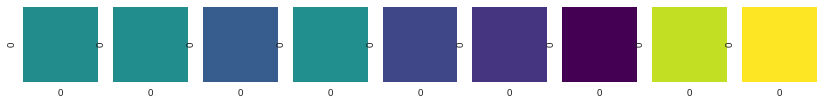

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


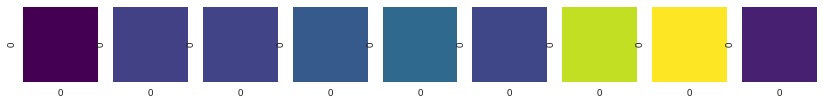

tensor(0.1051)


In [66]:
# 3d avg Ridge max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


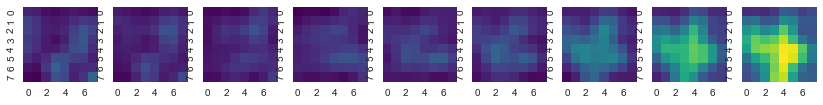

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


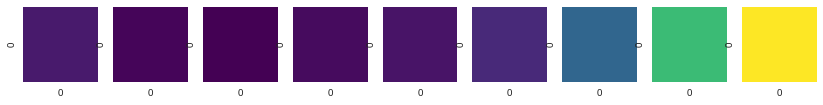

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


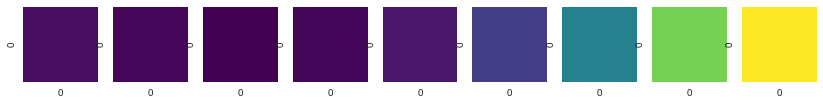

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


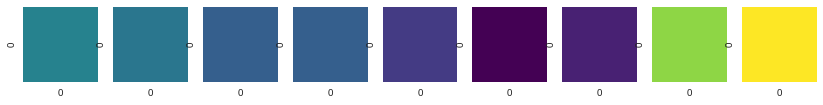

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


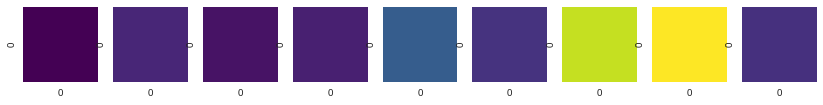

tensor(0.1013)


In [68]:
# 3d avg 1d avg Ridge max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


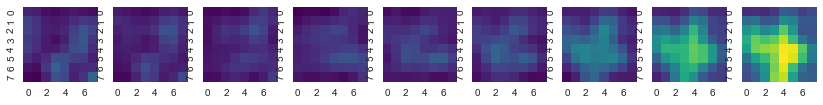

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


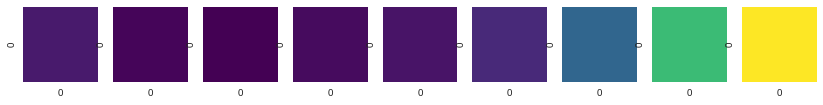

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


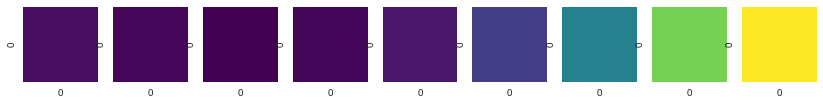

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


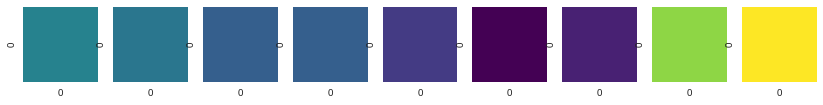

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


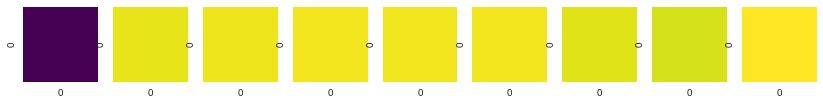

tensor(0.1365)


In [70]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,2,-1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


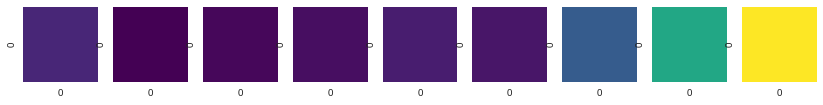

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


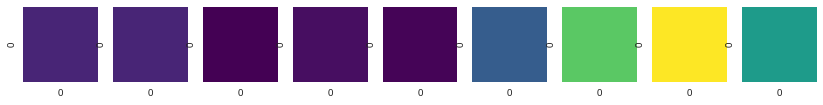

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


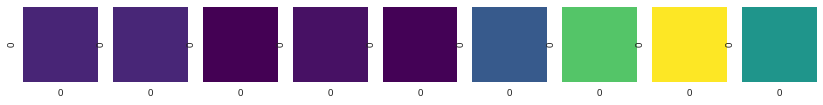

tensor(0.0914)


In [80]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,32,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


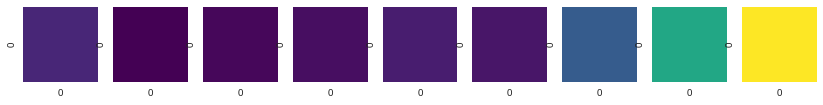

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


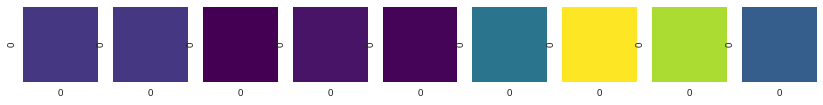

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


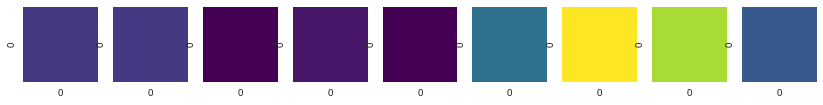

tensor(0.0971)


In [85]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,32,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


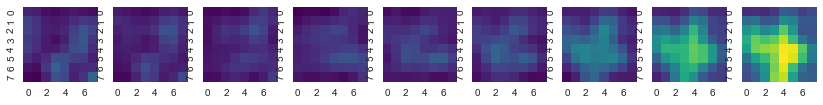

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


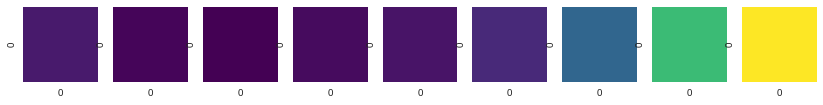

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


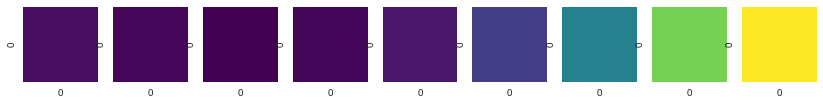

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


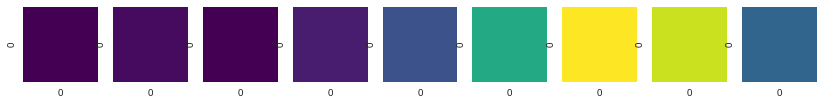

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


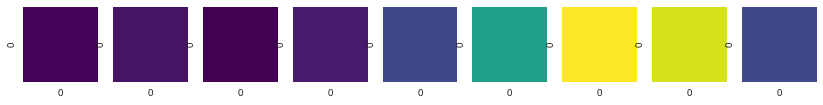

tensor(0.0889)


In [88]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


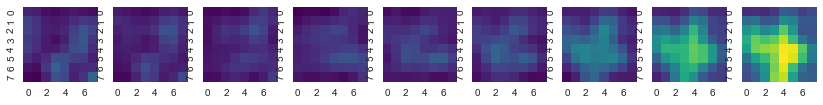

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


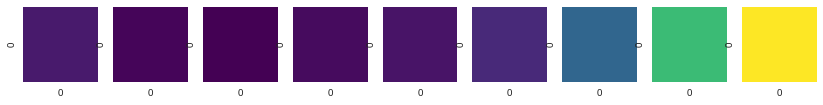

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


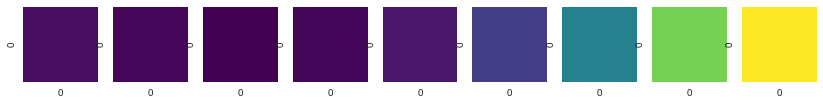

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


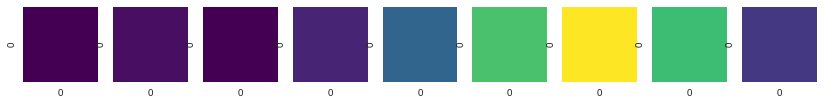

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


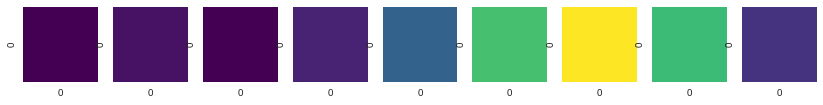

tensor(0.0878)


In [94]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,32,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

In [ ]:
-1,0,1
-2,0,2
1,-4,1 (zero-cross)

## Directed edge

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


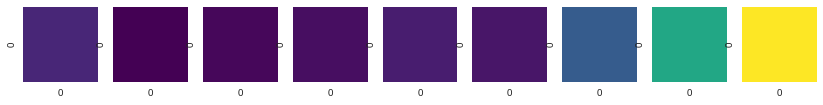

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


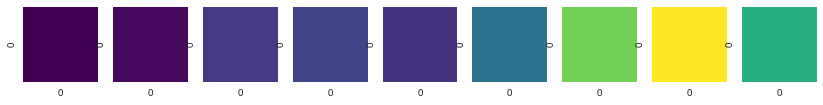

tensor(0.0924)


In [97]:
# Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


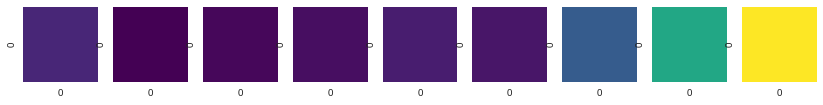

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


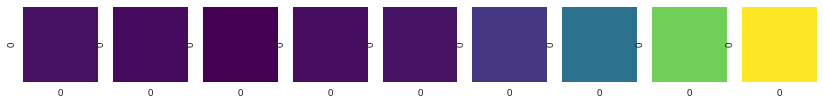

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


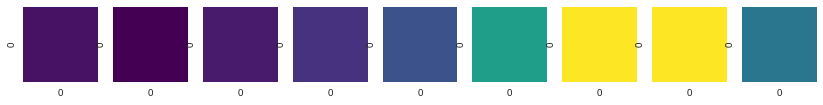

tensor(0.0896)


In [102]:
# 1d avg Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


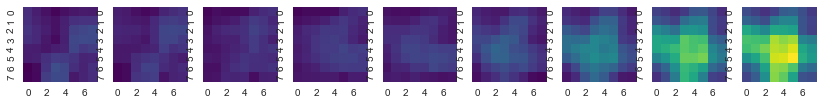

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


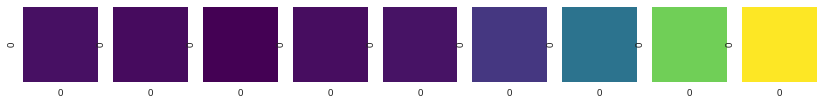

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


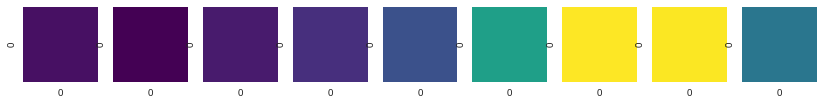

tensor(0.0896)


In [105]:
# 3d avg Edge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


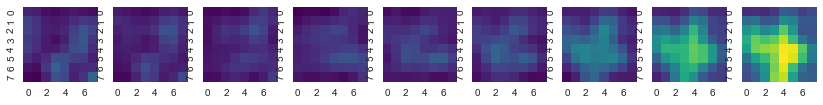

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


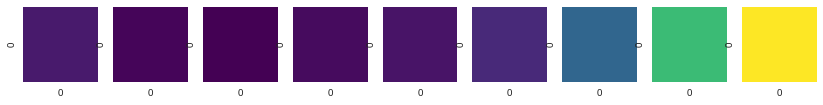

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


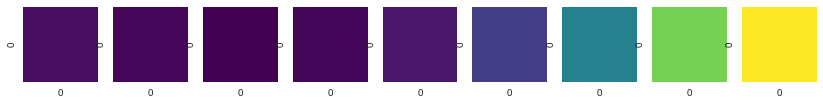

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


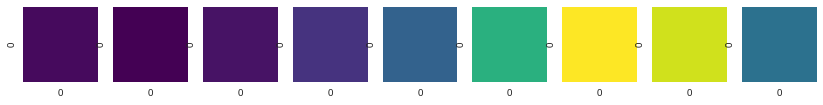

tensor(0.0890)


In [106]:
# 3d avg 1d avg Edge
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


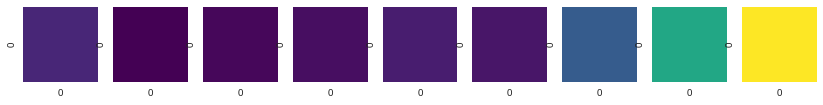

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


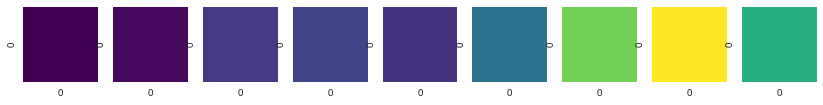

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


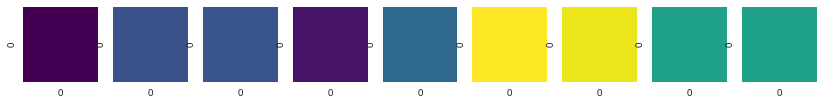

tensor(0.0994)


In [111]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


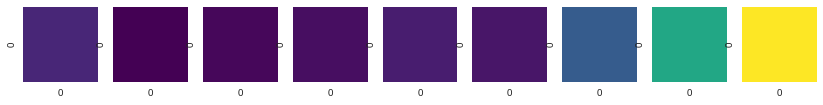

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


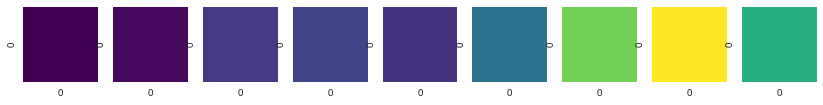

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


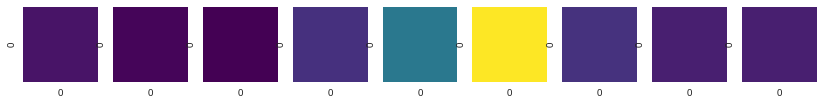

tensor(0.1067)


In [113]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


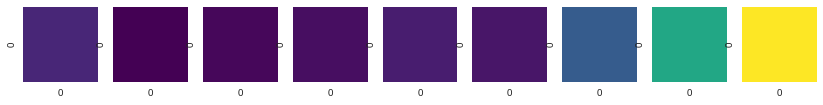

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


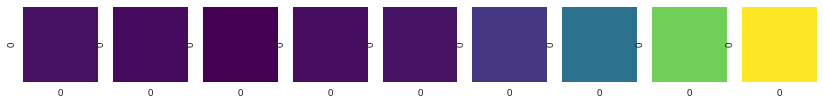

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


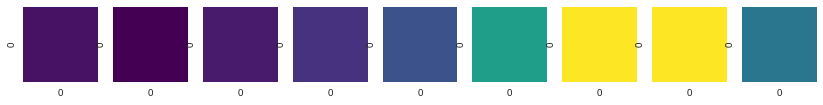

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


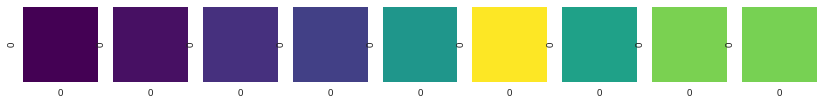

tensor(0.1161)


In [120]:
# 1d avg Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


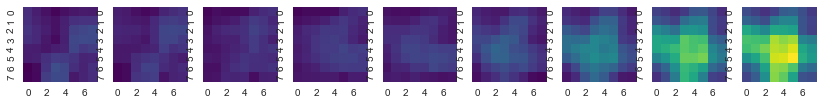

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


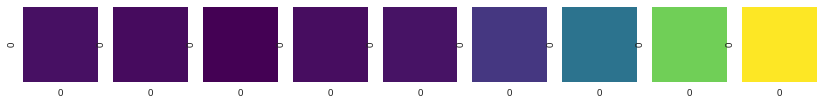

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


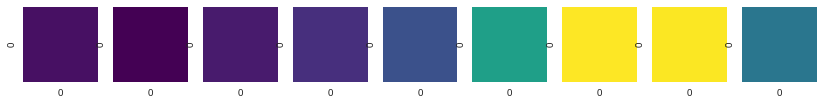

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


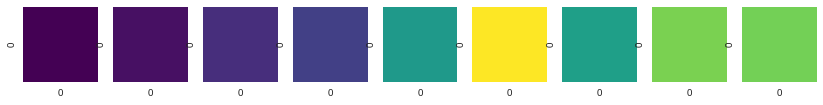

tensor(0.1150)


In [124]:
# 3d avg Ridge max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


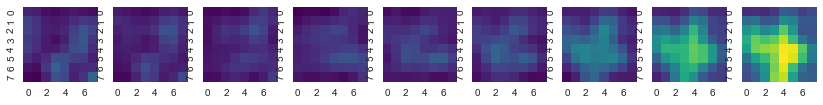

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


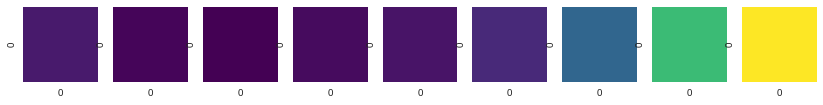

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


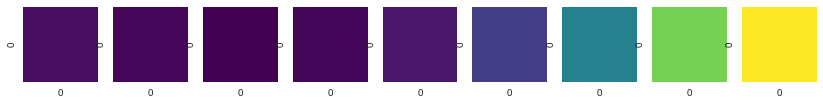

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


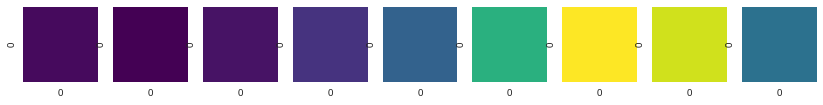

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


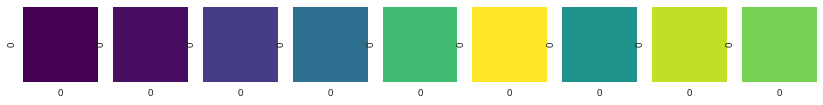

tensor(0.1138)


In [126]:
# 3d avg 1d avg Ridge max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


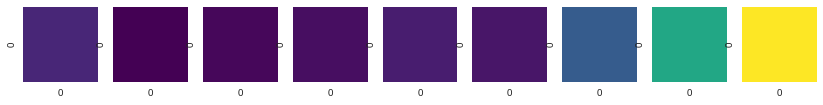

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


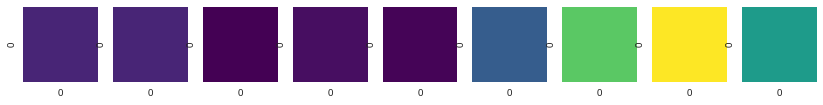

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


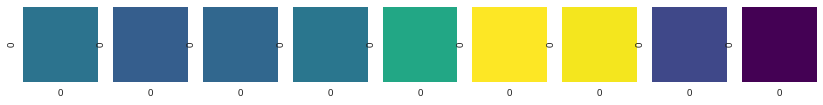

tensor(0.0975)


In [137]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=2)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


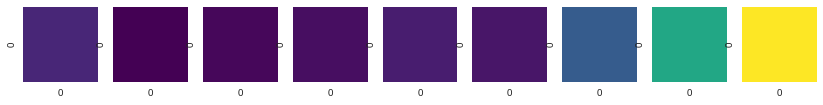

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


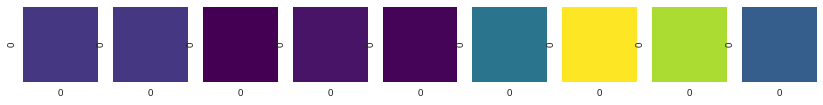

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


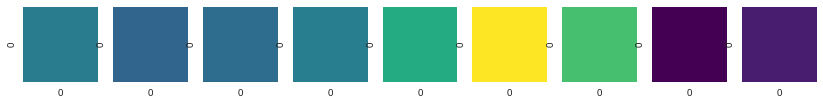

tensor(0.0975)


In [142]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=2)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


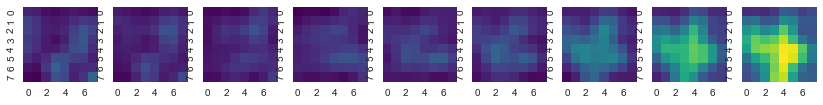

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


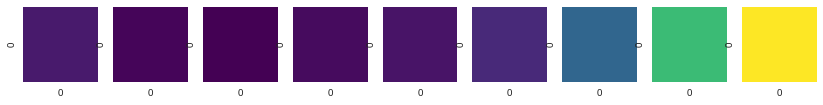

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


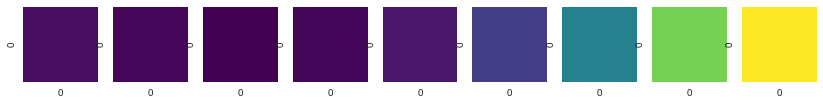

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


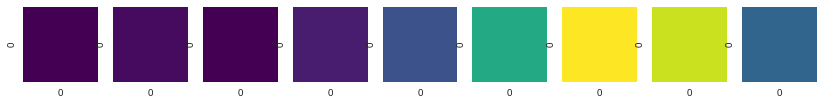

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


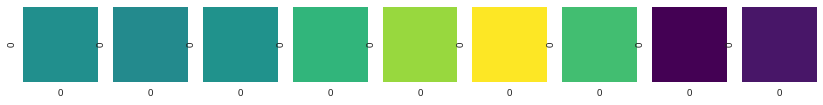

tensor(0.0899)


In [147]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=3)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


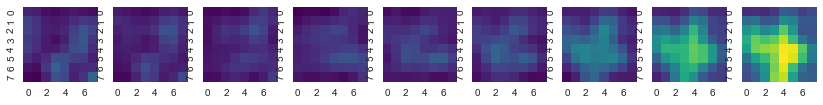

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


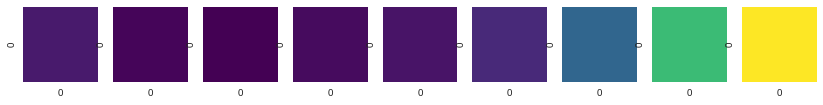

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


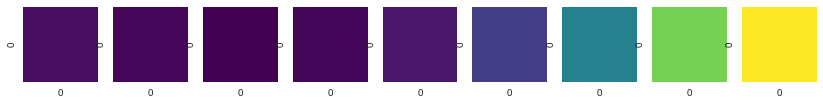

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


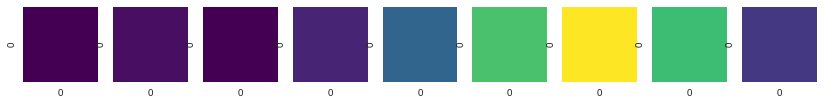

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


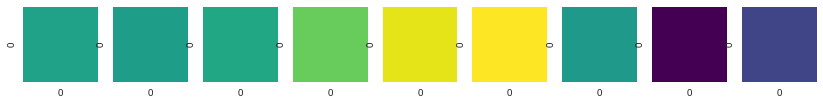

tensor(0.0849)


In [151]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=3)

## Laplacian edge

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


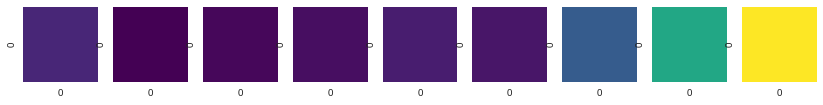

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


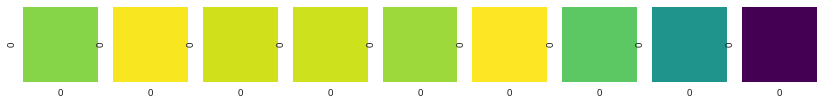

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


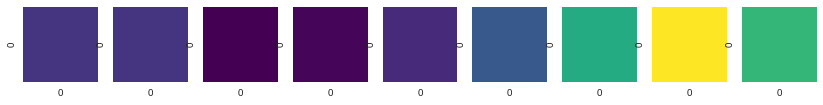

tensor(0.0941)


In [158]:
# Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


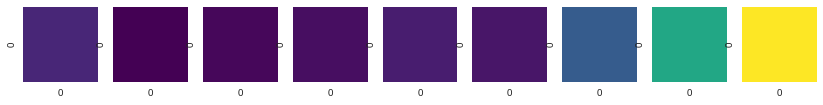

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


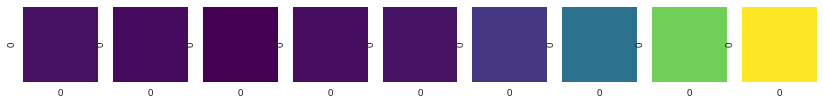

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


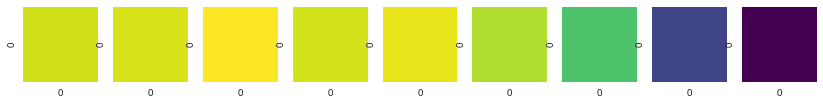

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


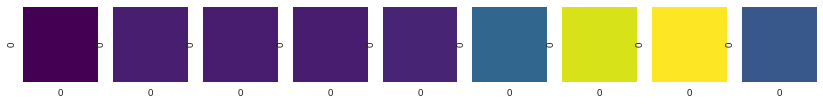

tensor(0.0904)


In [160]:
# 1d avg Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


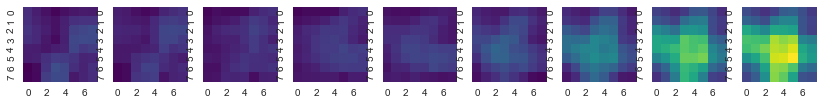

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


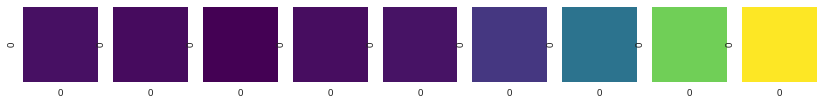

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


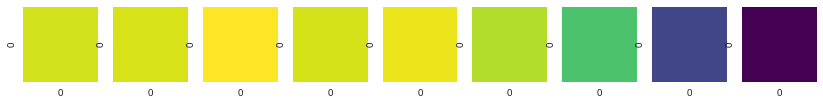

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


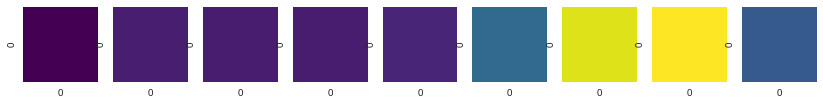

tensor(0.0907)


In [163]:
# 3d avg Laplacian max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


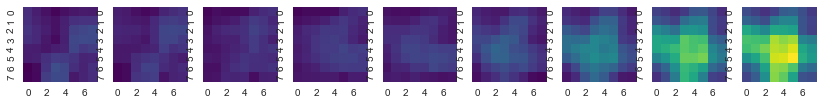

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


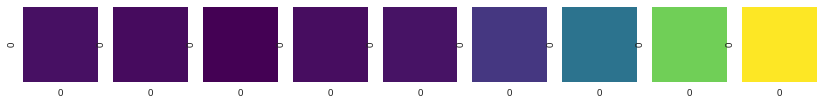

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


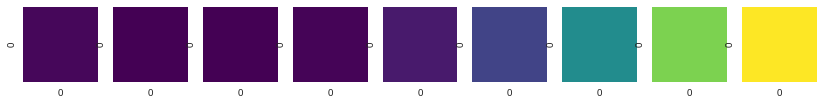

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


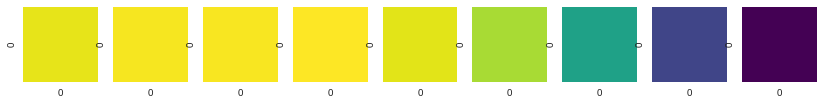

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


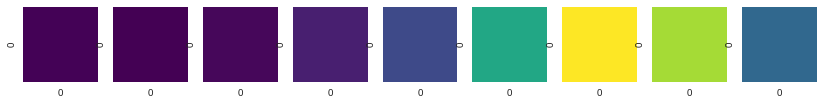

tensor(0.0882)


In [168]:
# 3d avg 1d avg Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


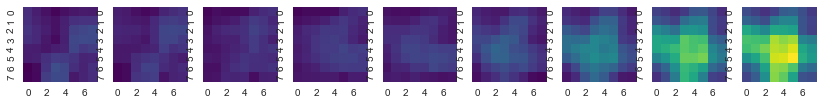

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


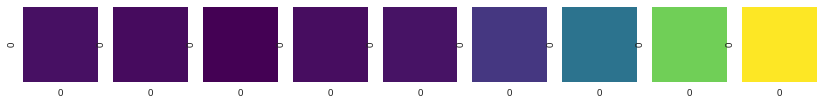

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


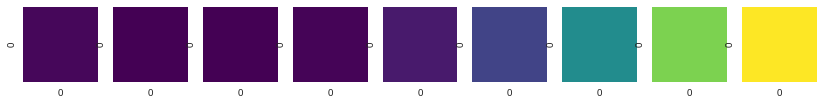

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


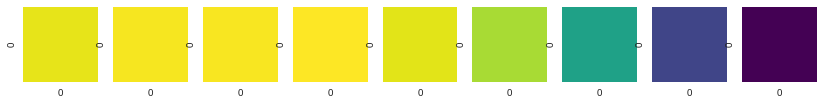

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


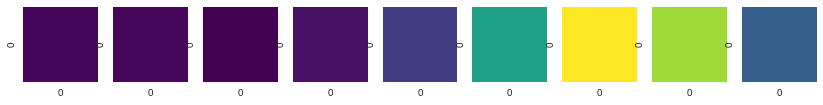

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


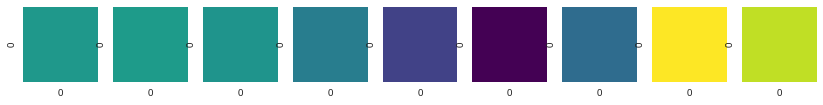

tensor(0.0889)


In [181]:
# 3d avg 1d avg Laplacian max-min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=0)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


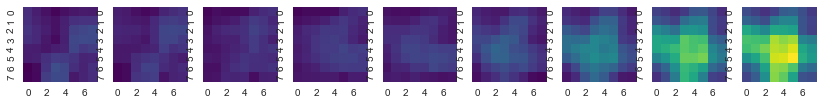

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


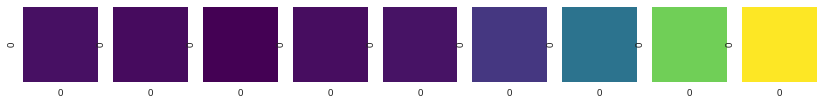

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


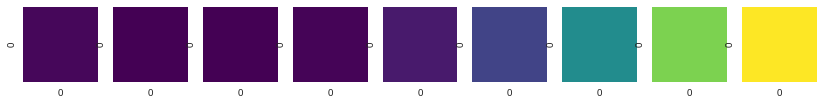

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


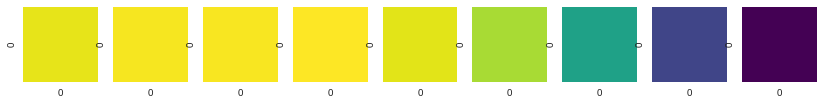

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


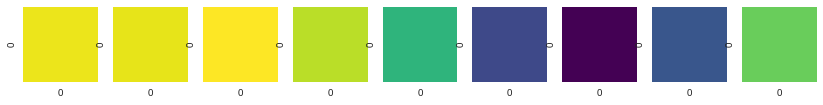

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


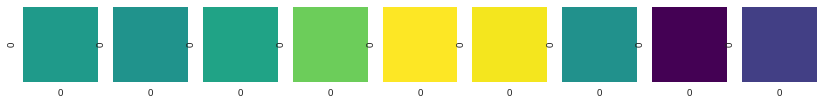

tensor(0.0972)


In [179]:
# 3d avg 1d avg Laplacian max/min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[0,:,None,None], targs[0])
score_data(x, targs, offset=2)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


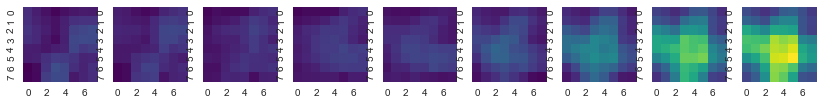

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


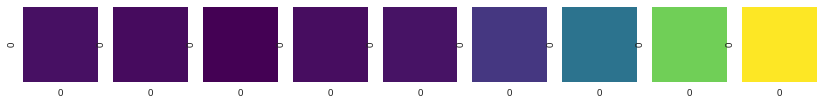

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


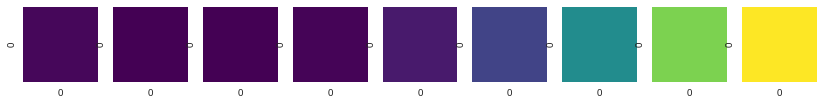

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


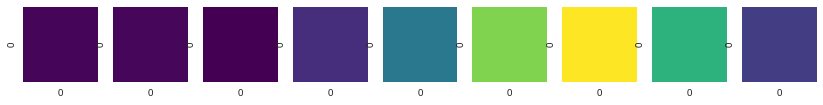

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


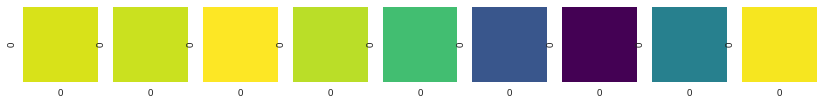

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


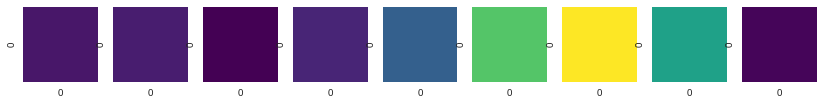

tensor(0.0880)


In [192]:
# 3d avg 1d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_div_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
plot_pred(-x[0,:,None,None], targs[0])
score_data(-x, targs, offset=1)

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


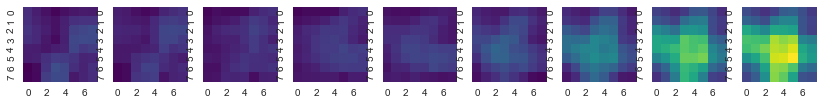

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


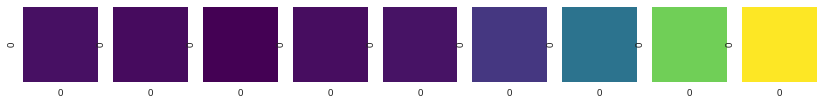

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


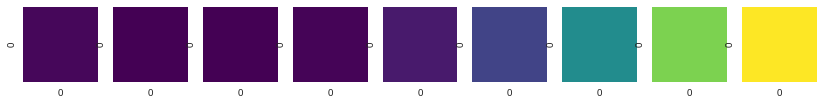

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


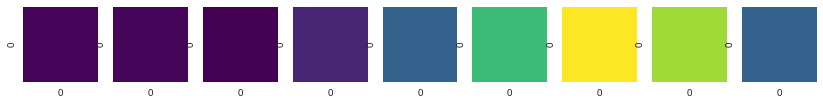

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


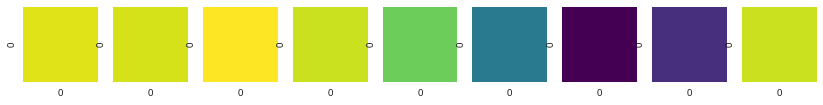

Zero-ordered target layer ID (including ladel bottom layer): tensor([7.])


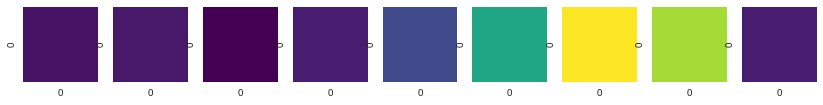

tensor(0.0882)


In [191]:
# 3d avg 1d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[0], targs[0])
x = get_layer_avgs(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_1d_avg(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_max_sub_mean(x)
plot_pred(x[0,:,None,None], targs[0])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[0,:,None,None], targs[0])
plot_pred(-x[0,:,None,None], targs[0])
score_data(-x, targs, offset=1)